In [249]:

import pandas as pd

In [300]:
df = pd.read_csv("2500_CEQA_reports_cleaned.csv")
df["Location Total Acres"] = df["Location Total Acres"].astype(str).apply(lambda x: x.replace(",", "")).astype(float)

In [251]:
# review_for_josh = df[df["Document Type"]=="NOD"].groupby(["SCH Number", "Document Type"]).size().reset_index()
# review_for_josh = df[df["SCH Number"].isin(review_for_josh[review_for_josh[0]>2]["SCH Number"])]
# review_for_josh = review_for_josh.groupby(["SCH Number"]).agg({'Lead Agency Name': lambda x: x.tolist(),
#                                                 'Document Title':lambda x: x.tolist(), 
#                                                 'Document Type':lambda x: x.tolist(),
#                                                 'Contact Authority': lambda x: x.tolist(),
#                                                 'Counties':lambda x: x.tolist(),
#                                                 'Cities': lambda x: x.tolist(),
#                                                   'NOD Approved Date':lambda x: x.tolist(),})
# review_for_josh.to_csv("review_for_josh.csv")

## Steps:
1. consider approved based on the fact that `NOD Approved By Lead Agency` approved it or not.
2. fill the NaNs in `NOD Approved Date` with `NOC State Review End Date` or `NOC Local Review End Date`
3. create a grouped file based on SCH Number and Lead Agency Name.
    - while grouping we take a mean for acreage
    - time span if taken by using the absolute values of `NOD Approved Date - Received`
4. while creating the plots for `Counties` and `Lead Agency`, only those values are considered where the support is more than 10. So only for Counties which occur more than 10 times in the data are considered.
5. TODO: Need to collect the data for amount of energy that will be generated for each Project Description

In [253]:
df = df[df["Document Type"].isin([ 'NOD', 'EIR','MND','NEG' ])]
df["approved"] = df["NOD Approved By Lead Agency"].apply(lambda x: 1 if x=="Yes" else 0 if x=="No" else -1)

In [255]:
df["NOD Approved Date"] = df["NOD Approved Date"].fillna(df["NOC State Review End Date"])
df["NOD Approved Date"] = df["NOD Approved Date"].fillna(df["NOC Local Review End Date"])


In [256]:

df = df[df["NOD Approved Date"].notna()].groupby(["SCH Number", "Lead Agency Name"]).agg({
    "Location Total Acres": "mean",
    "Counties": lambda x: x.unique()[0],
    "approved": max,
    "NOD Approved Date": max,
    "Received": min 
}).reset_index()


In [257]:
df.Counties.fillna("", inplace=True)
df.approved = df.approved.apply(lambda x: 0 if x==-1 else x)
df.Counties = df.Counties.apply(lambda x: x.split(",")[0])

list_of_counties = df["Counties"].value_counts()
list_of_counties = list_of_counties[list_of_counties>10].index.tolist()

<Axes: title={'center': 'Counties with highest % of approval rate'}, xlabel='Counties'>

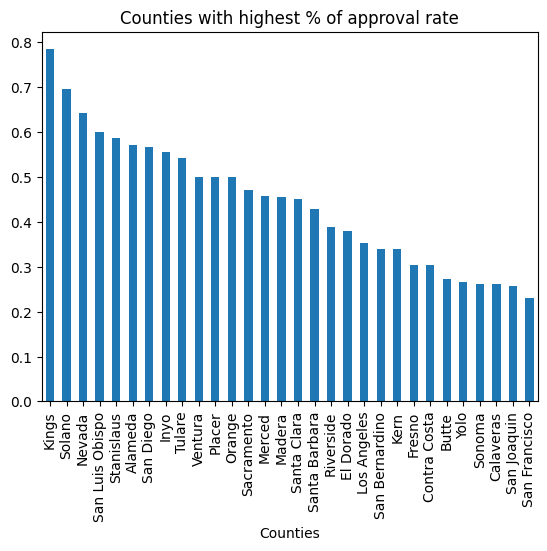

In [258]:
( (df[(df.approved==1) & (df.Counties.isin(list_of_counties))].Counties.value_counts()) / (
    df[df.Counties.isin(list_of_counties)].Counties.value_counts())
    ).sort_values(ascending=False)[:30].plot(
        kind="bar", 
        title = "Counties with highest % of approval rate"
    )

<Axes: title={'center': 'Counties with highest % of disapproval rate'}, xlabel='Counties'>

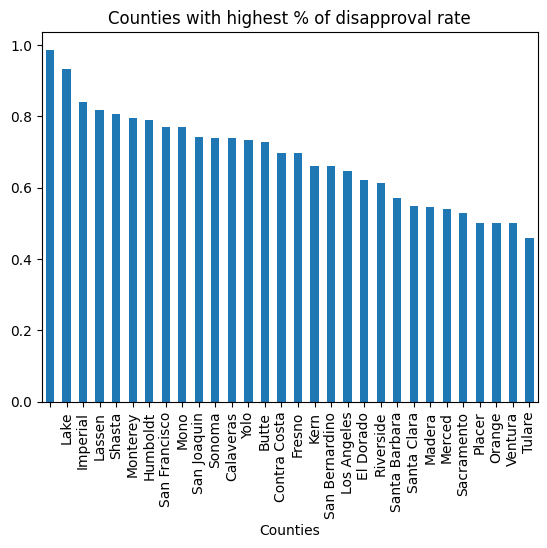

In [259]:
( (df[(df.approved==0) & (df.Counties.isin(list_of_counties))].Counties.value_counts()) / (
    df.Counties.value_counts())
    ).sort_values(ascending=False)[:30].plot(
        kind="bar", 
        title = "Counties with highest % of disapproval rate")

<Axes: title={'center': 'Lead agencies with highest % of approval rate'}, xlabel='Lead Agency Name'>

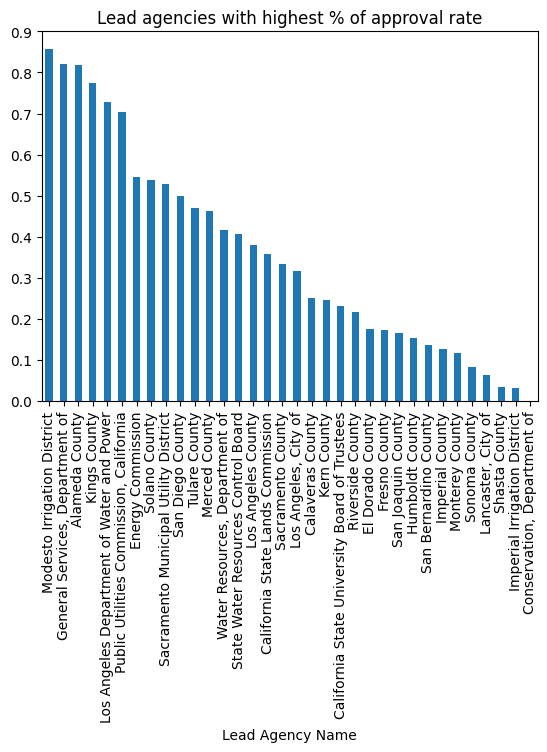

In [260]:
list_of_lead_agency = df["Lead Agency Name"].value_counts()
list_of_lead_agency = list_of_lead_agency[list_of_lead_agency>10].index.tolist()

( (df[(df.approved==1) & (df["Lead Agency Name"].isin(list_of_lead_agency))]["Lead Agency Name"].value_counts()) / (
    df[df["Lead Agency Name"].isin(list_of_lead_agency)]["Lead Agency Name"].value_counts())
    ).sort_values(ascending=False).plot(
    kind="bar", title = "Lead agencies with highest % of approval rate")

<Axes: title={'center': 'Lead agencies with highest % of disapproval rate'}, xlabel='Lead Agency Name'>

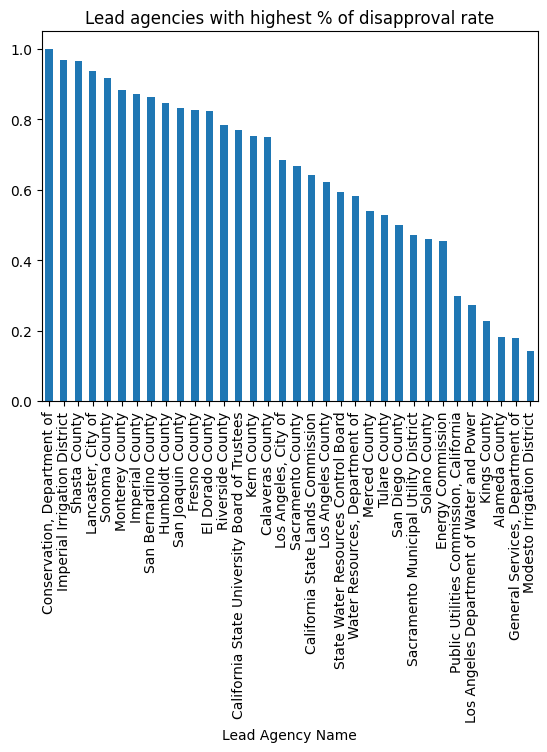

In [261]:
( (df[(df.approved==0) & (df["Lead Agency Name"].isin(list_of_lead_agency))]["Lead Agency Name"].value_counts()) / (
    df[df["Lead Agency Name"].isin(list_of_lead_agency)]["Lead Agency Name"].value_counts())
    ).sort_values(ascending=False).plot(
    kind="bar", title = "Lead agencies with highest % of disapproval rate")

<Axes: title={'center': 'Size of projects with NOD'}, ylabel='Frequency'>

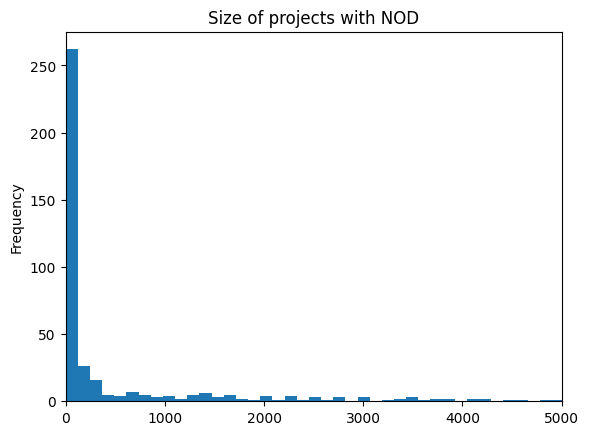

In [262]:

df[(df.approved==1) & (df["Counties"].isin(list_of_counties))]["Location Total Acres"].plot(
        kind = "hist", bins=500, xlim=(0,5000), title="Size of projects with NOD")

<Axes: title={'center': 'Size of projects without NOD'}, ylabel='Frequency'>

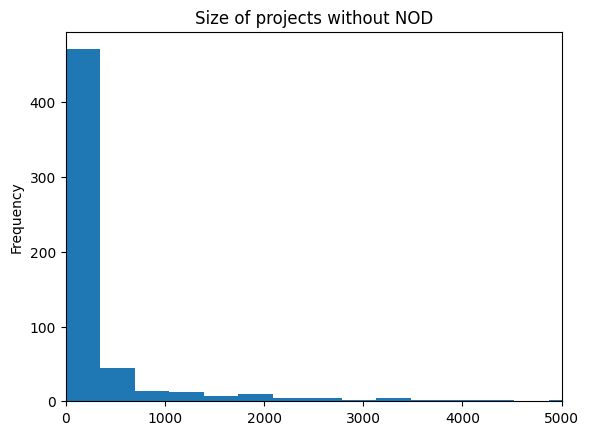

In [263]:
df[(df.approved==0) & (df["Counties"].isin(list_of_counties))]["Location Total Acres"].plot(
        kind = "hist", bins=1000, xlim=(0,5000), title="Size of projects without NOD")

In [272]:
df["Received"] = pd.to_datetime(pd.Series(df["Received"]))
df["NOD Approved Date"] = pd.to_datetime(pd.Series(df["NOD Approved Date"]))
df["span"] = abs(df["NOD Approved Date"] - df["Received"]).dt.days/365

<Axes: title={'center': 'no. of years taken for approval'}, ylabel='Frequency'>

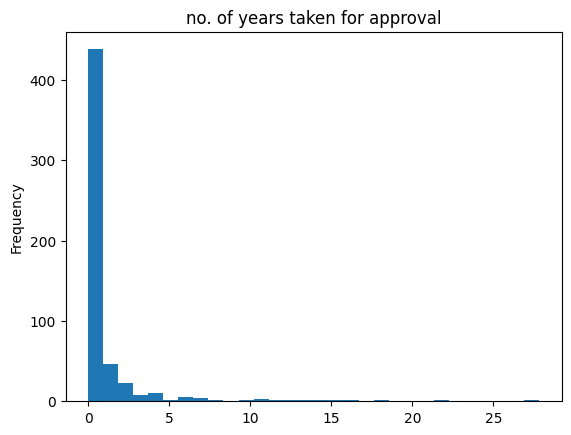

In [274]:
(df[df.approved==1].span).plot(kind="hist", bins=30, title = "no. of years taken for approval")

<Axes: title={'center': 'no. of years taken for approval'}, ylabel='Frequency'>

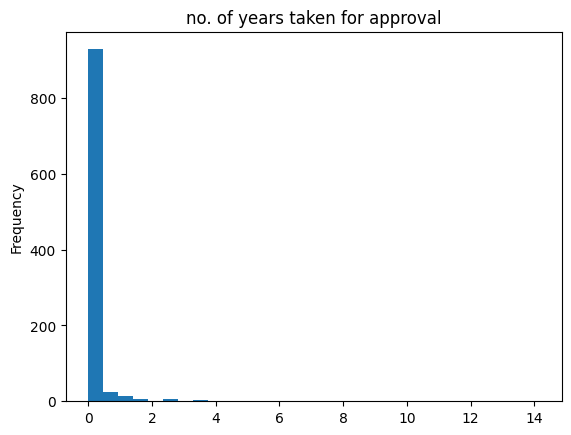

In [275]:
(df[df.approved==0].span).plot(kind="hist", bins=30, title = "no. of years taken for approval")

In [290]:
df[["span", "Location Total Acres"]].describe()

,span,Location Total Acres
count,1544.000000,1083.000000
mean,0.531021,1273.486538
std,1.762381,11632.460773
min,0.000000,0.020000
25%,0.079452,6.750000
50%,0.090411,40.000000
75%,0.227397,296.833333
max,27.816438,347941.000000


In [296]:
df[["span", "Location Total Acres"]].corr()

,span,Location Total Acres
span,1.000000,0.025199
Location Total Acres,0.025199,1.000000


<Axes: title={'center': 'relation between time and acreage of project (approved)'}, xlabel='span', ylabel='Location Total Acres'>

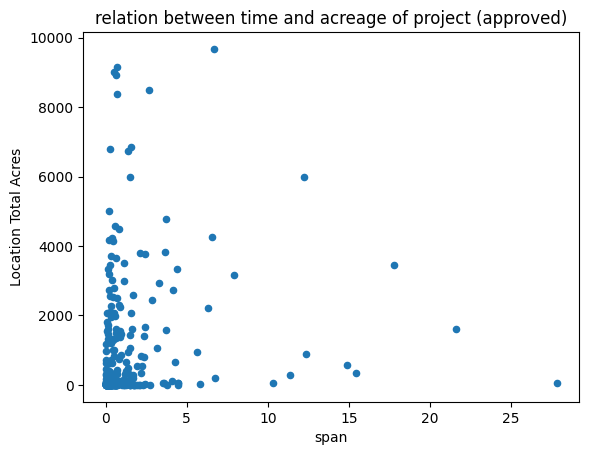

In [297]:
df[(df["Location Total Acres"]<10000) & (df.approved==1)][["span", "Location Total Acres"
]].plot.scatter(x="span", y="Location Total Acres",
title = "relation between time and acreage of project (approved)")

<Axes: title={'center': 'relation between time and acreage of project (not approved)'}, xlabel='span', ylabel='Location Total Acres'>

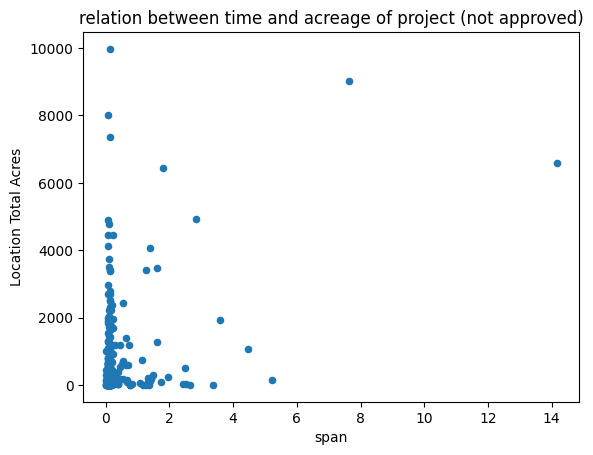

In [298]:
df[(df["Location Total Acres"]<10000) & (df.approved==0)][[
     "span", "Location Total Acres"]].plot.scatter(
         x="span", y="Location Total Acres",
         title = "relation between time and acreage of project (not approved)")

In [133]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [134]:
import numpy as np

# regular expression import
import re

# uni-code library
import unicodedata

# natural language toolkit library/modules
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

In [135]:
def basic_clean(string):
    '''
    This function takes in a string and
    returns the string normalized.
    '''
    string = unicodedata.normalize('NFKD', string)\
             .encode('ascii', 'ignore')\
             .decode('utf-8', 'ignore')
    string = re.sub(r'[^\w\s]', '', string).lower()
    return string

def tokenize(string):
    '''
    This function takes in a string and
    returns a tokenized string.
    '''
    # Create tokenizer.
    tokenizer = nltk.tokenize.ToktokTokenizer()

    # Use tokenizer
    string = tokenizer.tokenize(string, return_str = True)

    return string

def stem(string):
    '''
    This function takes in a string and
    returns a string with words stemmed.
    '''
    # Create porter stemmer.
    ps = nltk.porter.PorterStemmer()
    
    # Use the stemmer to stem each word in the list of words we created by using split.
    stems = [ps.stem(word) for word in string.split()]
    
    # Join our lists of words into a string again and assign to a variable.
    string = ' '.join(stems)
    
    return string

def lemmatize(string):
    '''
    This function takes in string for and
    returns a string with words lemmatized.
    '''
    # Create the lemmatizer.
    wnl = nltk.stem.WordNetLemmatizer()

    # Use the lemmatizer on each word in the list of words we created by using split.
    lemmas = [wnl.lemmatize(word) for word in string.split()]

    # Join our list of words into a string again and assign to a variable.
    string = ' '.join(lemmas)
    
    return string

def remove_stopwords(string, extra_words = [], exclude_words = []):
    '''
    This function takes in a string, optional extra_words and exclude_words parameters
    with default empty lists and returns a string.
    '''
    # Create stopword_list.
    stopword_list = stopwords.words('english')
    stopword_list+=["Project", "project", "existing", "acre", "site", "construction", "new", 
    "proposed", "facility", "substation", "include", "approximately", "area", "includes", "located", "parcel"]
    
    # Remove 'exclude_words' from stopword_list to keep these in my text.
    stopword_list = set(stopword_list) - set(exclude_words)
    
    # Add in 'extra_words' to stopword_list.
    stopword_list = stopword_list.union(set(extra_words))

    # Split words in string.
    words = string.split()
    
    # Create a list of words from my string with stopwords removed and assign to variable.
    filtered_words = [word for word in words if word not in stopword_list]
    
    # Join words in the list back into strings and assign to a variable.
    string_without_stopwords = ' '.join(filtered_words)
    
    return string_without_stopwords

def clean(text):
    '''
    This function combines the above steps and added extra stop words to clean text
    '''
    return remove_stopwords(lemmatize(basic_clean(text)))

In [136]:
wc = WordCloud().generate(clean(" ".join(df_nod["Document Description"].dropna().unique().tolist())))
plt.imshow(wc)


NameError: name 'df_nod' is not defined

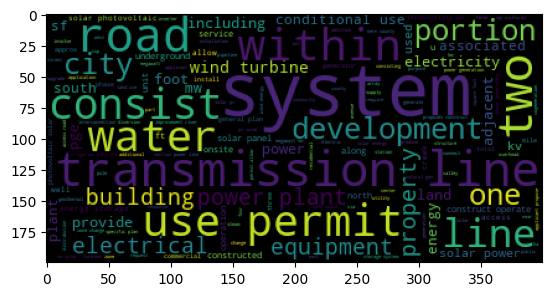

In [ ]:
wc = WordCloud().generate(clean(" ".join(df[~df["SCH Number"].isin(
    df_nod["SCH Number"])]["Document Description"].dropna().unique().tolist())))
plt.imshow(wc)

In [273]:
df["Location Zip Code"].isna().sum()

1467

In [27]:
from geopy.geocoders import Nominatim

/Users/ishitadaga/Downloads/booksum/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [28]:
geolocator = Nominatim(user_agent="ishita")
loc = geolocator.geocode(  """35°8'33.34"N 117°58'7.31"W""")
loc.latitude

35.14259447527608

In [20]:
# df.loc[df["Location Coordinates"].isna(), []

# from lat_lon_parser import parse
# parse("""35°8'33.34"N 117°58'7.31"W""")

TypeError: to_dec_deg() takes from 0 to 4 positional arguments but 6 were given

In [74]:
df_nod_all = df[df["SCH Number"].isin(df_nod["SCH Number"].unique())]

In [75]:
# df_nod_all[['NOD Approved Date', 'NOC Local Review End Date', 'Posted', 'Received']]
df_nod_all["Received"] = pd.to_datetime(pd.Series(df_nod_all["Received"]))

/var/folders/tl/nwztdf3n16s28rt4b8lv28rc0000gn/T/ipykernel_73233/3990143290.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nod_all["Received"] = pd.to_datetime(pd.Series(df_nod_all["Received"]))


In [76]:
def myfunc(row):
    temp = row[row["Received"]==row["Received"].max()][-1:]
    assert temp.shape[0]==1
    return pd.DataFrame({"Document Type": temp["Document Type"],
            "Received": temp["Received"],
            "Counties":temp["Counties"],
            "Lead Agency Name": temp["Lead Agency Name"]})

def myfuncmin(row):
    temp = row[row["Received"]==row["Received"].min()][-1:]
    assert temp.shape[0]==1
    return pd.DataFrame({"Document Type": temp["Document Type"],
            "Received": temp["Received"],
            "Counties":temp["Counties"],
            "Lead Agency Name": temp["Lead Agency Name"]})

df_nod_received = df_nod_all.groupby("SCH Number").apply(myfunc).reset_index()
df_intial_received = df_nod_all.groupby("SCH Number").apply(myfuncmin).reset_index()


In [77]:
df_intial_received = df_intial_received[df_intial_received["Document Type"]!="NOD"]

In [78]:
df_nod_received = df_nod_received[df_nod_received["Document Type"]=="NOD"]

In [79]:
dftimeline = df_nod_received.merge(df_intial_received, on=["SCH Number", "Counties", 
"Lead Agency Name"], suffixes=["_Final", "_Intial"])

In [80]:
dftimeline["span"] = (dftimeline["Received_Final"] - dftimeline["Received_Intial"]).dt.days/365

<Axes: title={'center': 'no. of years taken for approval'}, ylabel='Frequency'>

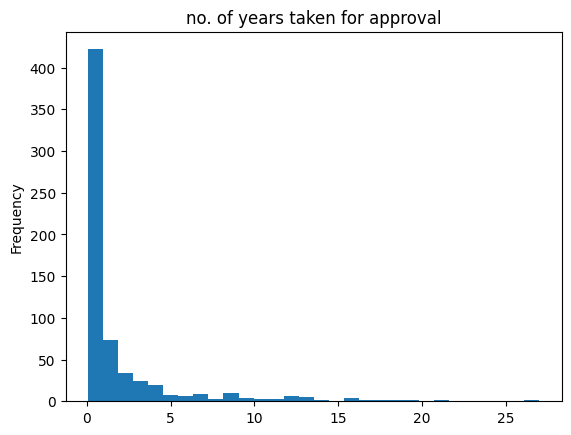

In [81]:
(dftimeline.span).plot(kind="hist", bins=30, title = "no. of years taken for approval")

<Axes: title={'center': 'Counties taking most time'}, xlabel='Counties'>

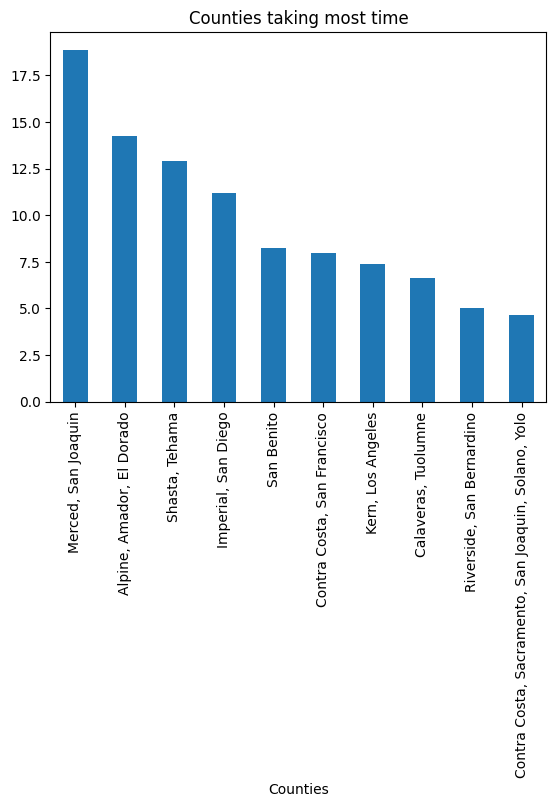

In [82]:
dftimeline.groupby(['Counties'])["span"].median().sort_values(ascending=False)[:10].plot(kind="bar", 
title = "Counties taking most time")
# dftimeline.groupby(['Counties'])["span"].mean().sort_values(ascending=True)[:10].plot(kind="bar", 
# title = "Counties taking least time")

<Axes: title={'center': 'Lead Agency Name taking most time'}, xlabel='Lead Agency Name'>

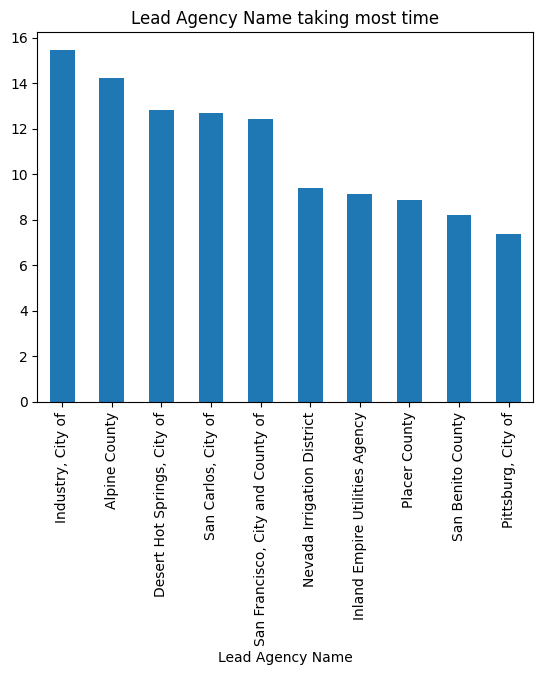

In [86]:
dftimeline.groupby(['Lead Agency Name'])["span"].median().sort_values(ascending=False)[:10].plot(kind="bar", 
title = "Lead Agency Name taking most time")
# dftimeline.groupby(['Lead Agency Name'])["span"].median().sort_values(ascending=True)[:10].plot(kind="bar", 
# title = "Lead Agency Name taking least time")

In [24]:
def myfunc(row):
    return pd.DataFrame(row["Document Type"].value_counts().to_dict(), index=[0])

df_without_nod = df[df["Document Type"]!="NOD"]
df_doc_perc_leadagency = df_without_nod.groupby(["Lead Agency Name"]).apply(myfunc).reset_index()
df_doc_perc_leadagency.fillna(0, inplace=True)
df_doc_perc_leadagency[["MND", "NEG", "EIR", "NOE"]] = df_doc_perc_leadagency[["MND", "NEG", "EIR", "NOE"]].div(
    df_doc_perc_leadagency[["MND", "NEG", "EIR", "NOE"]].sum(axis=1), axis=0)

df_doc_perc_county = df_without_nod.groupby(["Counties"]).apply(myfunc).reset_index()
df_doc_perc_county.fillna(0, inplace=True)
df_doc_perc_county[["MND", "NEG", "EIR"]] = df_doc_perc_county[["MND", "NEG", "EIR"]].div(
    df_doc_perc_county[["MND", "NEG", "EIR"]].sum(axis=1), axis=0)


In [21]:
df_doc_perc_county[["Counties","EIR"]].sort_values("EIR")[-30:]

,Counties,EIR
41,Kings,4.0
103,Trinity,4.0
85,San Mateo,4.0
11,Butte,5.0
106,Ventura,5.0
35,"Imperial, Riverside",5.0
55,Merced,5.0
107,Yolo,5.0
22,El Dorado,6.0
75,"Riverside, San Bernardino",6.0


In [15]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt


In [56]:
def f(x):
    try:
        geo=geolocator.geocode(x+", CA")
        lat = geo.latitude
        long = geo.longitude
        return lat, long
    except: return (None, None)
df_doc_perc_county["latitude"], df_doc_perc_county["longitude"] = zip(*df_doc_perc_county["Counties"].map(f))

In [63]:
geometry = [Point(xy) for xy in zip(df_doc_perc_county[df_doc_perc_county["latitude"]!=""]["longitude"], 
                                    df_doc_perc_county[df_doc_perc_county["latitude"]!=""]["latitude"]
)]
gdf = GeoDataFrame(df_doc_perc_county, geometry=geometry)
world = gpd.read_file(gpd.datasets.get_path("cali "))

/var/folders/tl/nwztdf3n16s28rt4b8lv28rc0000gn/T/ipykernel_73233/1984872103.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


<Axes: >

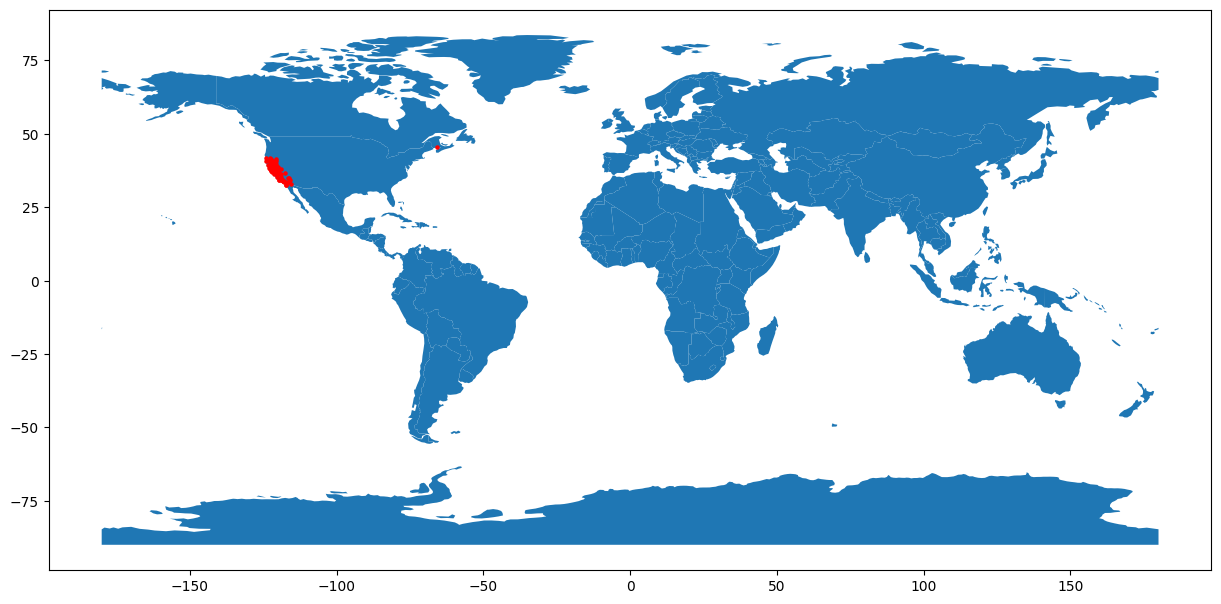

In [65]:
gdf.plot(ax=world.plot(figsize=(15,15)), marker='o', color='red', markersize=5)

In [70]:
import geodatasets

In [71]:
geodatasets.data

{'geoda': {'airbnb': {'url': 'https://geodacenter.github.io/data-and-lab//data/airbnb.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.airbnb',
   'description': 'Airbnb rentals, socioeconomics, and crime in Chicago',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 21,
   'details': 'https://geodacenter.github.io/data-and-lab//airbnb/',
   'hash': 'a2ab1e3f938226d287dd76cde18c00e2d3a260640dd826da7131827d9e76c824',
   'filename': 'airbnb.zip'},
  'atlanta': {'url': 'https://geodacenter.github.io/data-and-lab//data/atlanta_hom.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.atlanta',
   'description': 'Atlanta, GA region homicide counts and rates',
   'geometry_type': 'Polygon',
   'nrows': 90,
   'ncols': 24,
   'details': 'https://geodacenter.github.io/data-and-lab//atlanta_old/',
   'hash': 'a33a76e12168fe84361e60c88a9df4856730487305846c559715c89b1a2b5e09',
   'filename': 'atlanta_hom.zip',
   'members': ['atlanta_hom/atl_hom.geojson']},
  'cars': {'url': 'https://geodacenter.github.io/data-and-lab//data/Abandoned_Vehicles_Map.csv',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.cars',
   'description': '2011 abandoned vehicles in Chicago (311 complaints).',
   'geometry_type': 'Point',
   'nrows': 137867,
   'ncols': 21,
   'details': 'https://geodacenter.github.io/data-and-lab//1-source-and-description/',
   'hash': '6a0b23bc7eda2dcf1af02d43ccf506b24ca8d8c6dc2fe86a2a1cc051b03aae9e',
   'filename': 'Abandoned_Vehicles_Map.csv'},
  'charleston1': {'url': 'https://geodacenter.github.io/data-and-lab//data/CharlestonMSA.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.charleston1',
   'description': '2000 Census Tract Data for Charleston, SC MSA and counties',
   'geometry_type': 'Polygon',
   'nrows': 117,
   'ncols': 31,
   'details': 'https://geodacenter.github.io/data-and-lab//charleston-1_old/',
   'hash': '4a4fa9c8dd4231ae0b2f12f24895b8336bcab0c28c48653a967cffe011f63a7c',
   'filename': 'CharlestonMSA.zip',
   'members': ['CharlestonMSA/sc_final_census2.gpkg']},
  'charleston2': {'url': 'https://geodacenter.github.io/data-and-lab//data/CharlestonMSA2.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.charleston2',
   'description': '1998 and 2001 Zip Code Business Patterns (Census Bureau) for Charleston, SC MSA',
   'geometry_type': 'Polygon',
   'nrows': 42,
   'ncols': 60,
   'details': 'https://geodacenter.github.io/data-and-lab//charleston2/',
   'hash': '056d5d6e236b5bd95f5aee26c77bbe7d61bd07db5aaf72866c2f545205c1d8d7',
   'filename': 'CharlestonMSA2.zip',
   'members': ['CharlestonMSA2/CharlestonMSA2.gpkg']},
  'chicago_health': {'url': 'https://geodacenter.github.io/data-and-lab//data/comarea.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.chicago_health',
   'description': 'Chicago Health + Socio-Economics',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 87,
   'details': 'https://geodacenter.github.io/data-and-lab//comarea_vars/',
   'hash': '4e872adb552786eae2fcd745524696e5e4cd33cc9a6c032471c0e75328871401',
   'filename': 'comarea.zip'},
  'chicago_commpop': {'url': 'https://geodacenter.github.io/data-and-lab//data/chicago_commpop.zip',
   'license': 'NA',
   'attribution': 'Center for Spatial Data Science, University of Chicago',
   'name': 'geoda.chicago_commpop',
   'description': 'Chicago Community Area Population Percent Change for 2000 and 2010',
   'geometry_type': 'Polygon',
   'nrows': 77,
   'ncols': 9,
   'details': 'https://geodacenter.github.io/data-and-lab//commpop/',
   'hash': '1dbebb50c8ea47e2279ea819ef64ba793bdee2b88e4716bd6c6ec0e0d8e0e05b',
   'filename': 'c

In [30]:
x = [1, 20, 17]

for i in range(2, len(x)):
    x[i] = x[i]+min(x[i-1], x[i-2])
print(min(x[-1], x[-2]))

18


In [56]:
x = [73, 74, 75, 71, 69, 72, 76, 73]
# max_temp = x[-1]
res = [0]
for i in range(1, len(x)):
    # print(i)
    while res!=[] and x[i]>x[res[-1]]:
        # print(res)
        x[res[-1]] = i-res[-1]
        res.pop()
        # print(res)
    res.append(i)
while res:
    x[res[-1]] = 0
    res.pop()
    

In [65]:
x[:5]

[1, 1, 4, 2, 1]

In [71]:
x.index(1)

0

In [70]:
z